## Ejercicio 1
En la siguiente definición de modelo probabilístico cual es el _likelihood_, cual es el _a priori_ y cual el _a posteriori_.

$$
\begin{aligned}
y_i &\sim Normal(\mu, \sigma) \\
\mu &\sim Normal(0, 10) \\
\sigma &\sim HalfNormal(25)
\end{aligned}
$$

En este caso, tenemos que la distribución de y_i es la likelihood (es decir, la primera Normal) y los prios son la Normal de mu y la HalfNormal de sigma.

El posterior no está explícito acá, pero es basicamente
$$p(\mu, \sigma | y) \propto p(y | \mu, \sigma) * p(\mu) * p(\sigma)$$


## Ejercicio 2
En el modelo del punto 1 ¿cuántos parámetros hay en el posterior? o expresado de otra forma ¿cuántas dimensiones tiene el _a posteriori_?

Como lo defini antes, el posterior tiene 2 parametros: la media mu y la escala sigma.

## Ejercicio 3
En el siguiente modelo ¿cuál es el modelo lineal? ¿cuál el likelihood y cuantos parámetros hay en la distribución a posteriori?

$$
\begin{aligned}
y &\sim Normal(\mu, \epsilon) \\
\mu &= \alpha + \beta x \\
\alpha &\sim Normal(0, 10) \\
\beta &\sim Normal(0, 1) \\
\epsilon &\sim HalfNormal(25) \\
\end{aligned}
$$


En este caso, el modelo lineal es el conjunto de todas estas distribuciones. Si soy mas especifico, es la variable mu, que es una funcion lineal dependiente de x.

En este sentido tenemos la likelihood de y, que es la primera Normal.

La posterior tiene la pinta
$$p(\alpha, \beta, \epsilon | y) \propto p(y | \alpha, \beta, \epsilon) * p(\alpha) * p(\beta) * p(\epsilon) $$

Es decir, tiene 3 parametros: alpha, beta y epsilon

## Ejercicio 4
Usando el conjunto de datos `howell` (disponible junto con esta notebook) realice un modelo lineal del peso ($x$) versus la altura ($y$). Excluya a los menores de 18 años. Exponga los resultados.

In [1]:
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import xarray as xr
import bambi as bmb

In [2]:
howell = pd.read_csv("datos/howell.csv", delimiter= ";")

howell.head()

,altura,peso,edad,sexo
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


<Axes: xlabel='peso', ylabel='altura'>

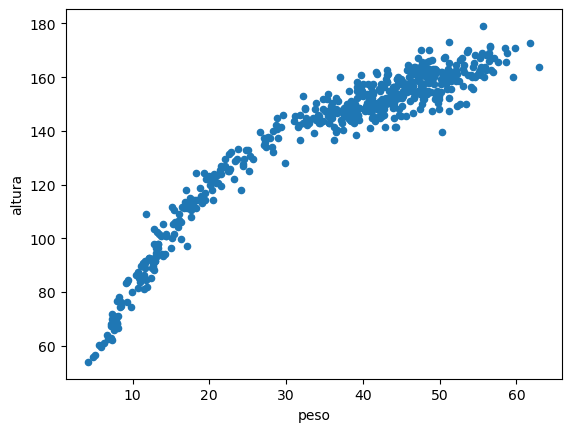

In [3]:
howell.plot("peso","altura",kind = "scatter")

In [4]:
howell_sin_menores = howell.loc[howell["edad"] > 18, :]
howell_sin_menores.reset_index(inplace=True)
x_3 = howell_sin_menores.peso
y_3 = howell_sin_menores.altura

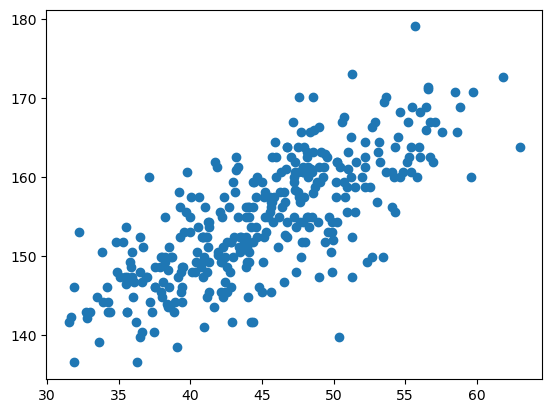

In [5]:
plt.scatter(x_3,y_3)

### Con bambi

In [6]:
modelo = bmb.Model('altura ~ peso', howell_sin_menores)

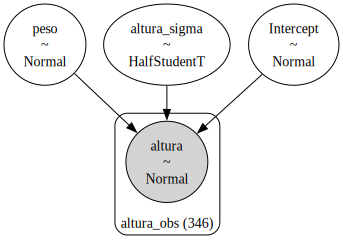

In [7]:
modelo.build()
modelo.graph()


In [8]:
idata = modelo.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [altura_sigma, Intercept, peso]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


c:\Users\admin\anaconda3\envs\estadistica2\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
c:\Users\admin\anaconda3\envs\estadistica2\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


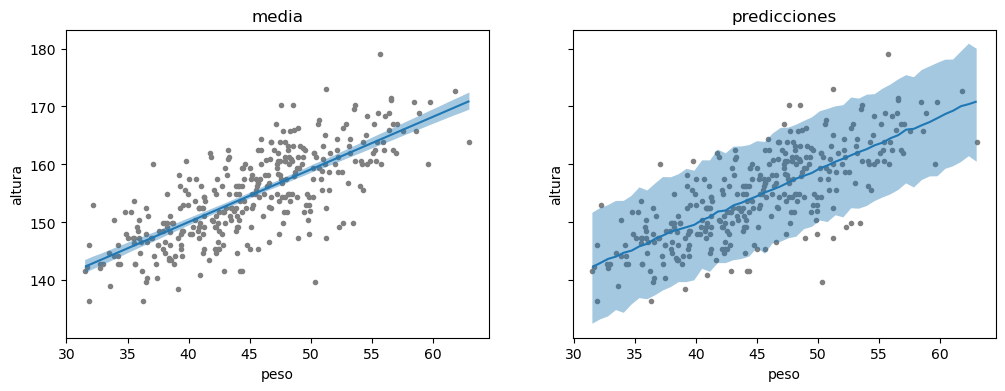

In [9]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4)) 
bmb.interpret.plot_predictions(modelo, idata, "peso", ax=axes[0])
bmb.interpret.plot_predictions(modelo, idata, "peso", pps=True, ax=axes[1])

axes[0].plot(howell_sin_menores.peso, howell_sin_menores.altura, ".", color="0.5",  zorder=-3)
axes[1].plot(howell_sin_menores.peso, howell_sin_menores.altura, ".", color="0.5", zorder=-3)
axes[0].set_title("media")
axes[1].set_title("predicciones");

In [10]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,113.758,1.886,110.203,117.190,0.032,0.023,3442.0,1512.0,1.0
altura_sigma,5.133,0.193,4.788,5.490,0.003,0.002,3064.0,1687.0,1.0
peso,0.908,0.042,0.834,0.989,0.001,0.001,3400.0,1470.0,1.0


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'altura_sigma'}>,
       <Axes: title={'center': 'peso'}>], dtype=object)

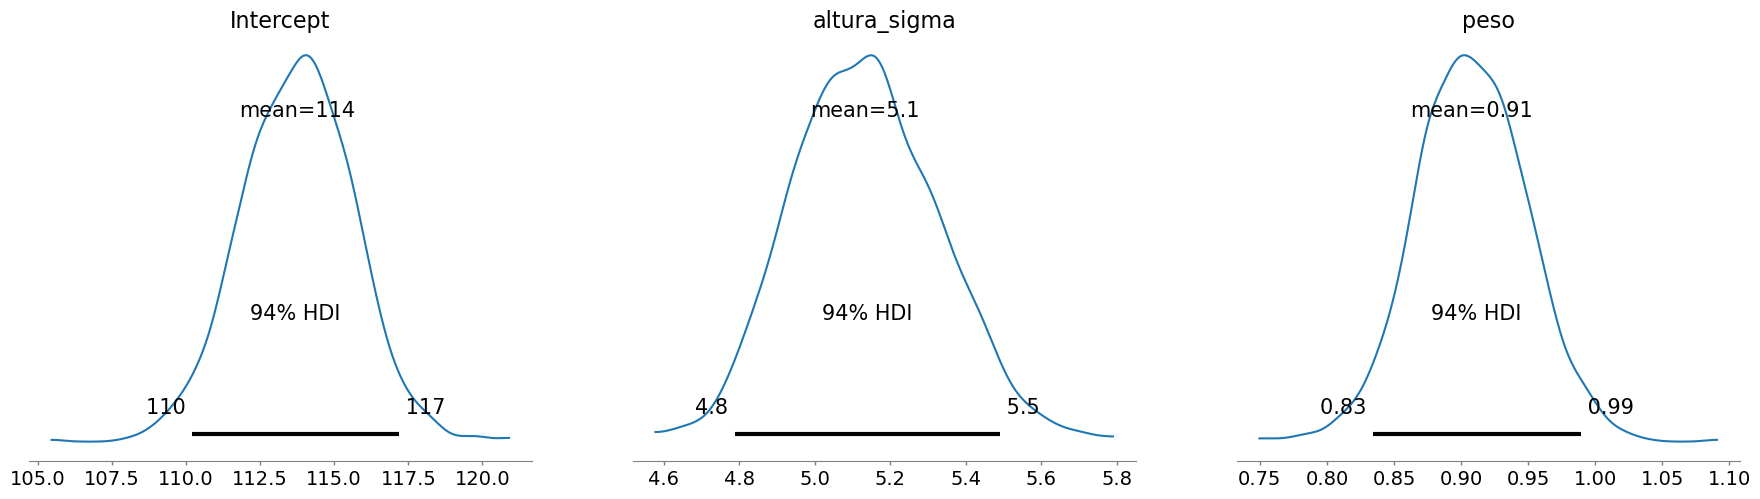

In [11]:
az.plot_posterior(idata)

### Con PYMC

Lo planteo como 

y ~ Normal($\mu$,$\sigma$)

$\mu$ = $\alpha$ + $\beta$ x

$\alpha$ ~ Normal(0,50)

$\beta$ ~ Normal(0,50)

$\sigma$ ~ HalfNormal(50)


Elijo 50 como hiperparametro ya que: 100 me parece mucho.

[insertar explicacion teorica de porque]

In [12]:
with pm.Model() as regresion_howell_1:
    x_shared = pm.Data("x_shared",x_3.values.astype(float))
    α = pm.Normal('α', mu=0, sigma=100)
    β = pm.Normal('β', mu=0, sigma=100)
    σ = pm.HalfNormal('σ', 100)
    μ = pm.Deterministic('μ', α + β * x_shared)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=y_3, shape = x_shared.shape)

In [13]:
with regresion_howell_1:
    idata_rh1 = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α, β, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

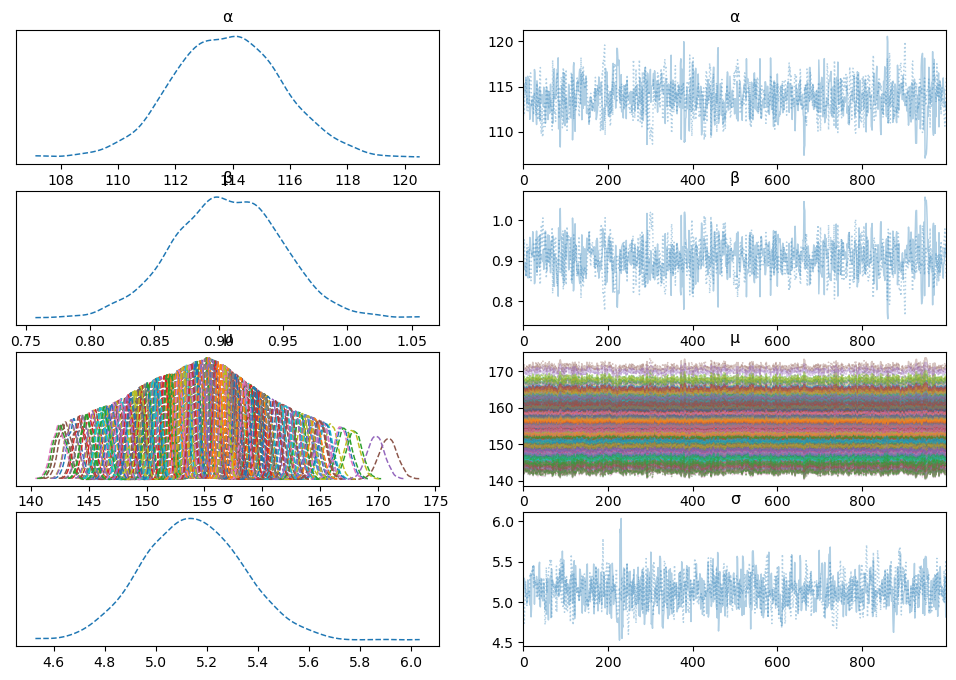

In [14]:
az.plot_trace(idata_rh1, combined=True)

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

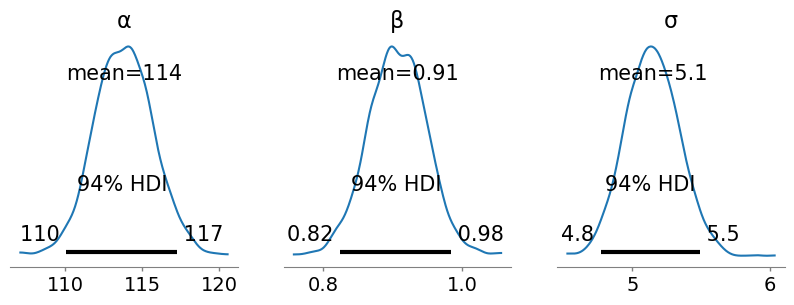

In [15]:
az.plot_posterior(idata_rh1, var_names=['~μ'], figsize=(10, 3))

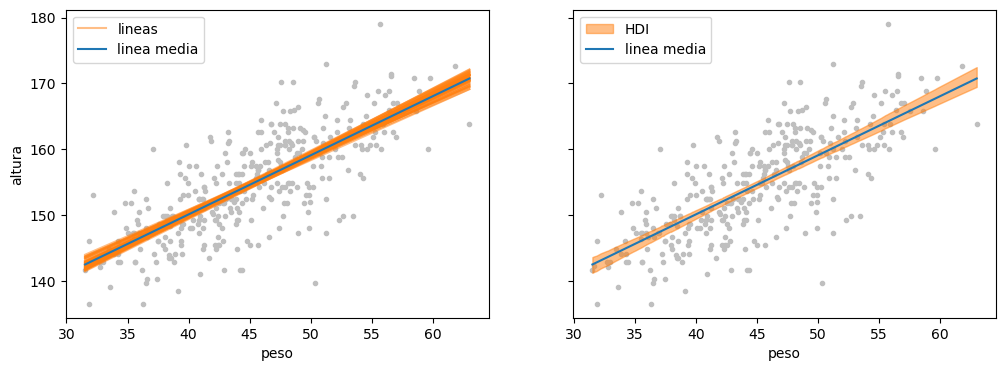

In [16]:
posterior = az.extract(idata_rh1, num_samples=50)
x_plot = xr.DataArray(np.linspace(x_3.min(), x_3.max(), 50), dims="plot_id")
linea_media = posterior['α'].mean() + posterior['β'].mean() * x_plot
lineas = posterior['α'] + posterior['β'] * x_plot
hdi_lines = az.hdi(idata_rh1.posterior['μ'])


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(x_3, y_3,  '.', color="0.75",  zorder=-3)
lines_ = axes[0].plot(x_plot, lineas.T, c='C1', alpha=0.5, label='lineas')
plt.setp(lines_[1:], label="_")
axes[0].plot(x_plot, linea_media, c='C0', label='linea media')
axes[0].set_xlabel('peso')
axes[0].set_ylabel('altura')
axes[0].legend()

axes[1].plot(x_3, y_3, '.', color="0.75",  zorder=-3)
idx = np.argsort(x_3.values)
axes[1].fill_between(x_3[idx], hdi_lines["μ"][:,0][idx], hdi_lines["μ"][:,1][idx],
                     color="C1", label='HDI', alpha=0.5)
axes[1].plot(x_plot, linea_media, c='C0', label='linea media')
axes[1].set_xlabel('peso')
axes[1].legend();

In [17]:
pm.sample_posterior_predictive(idata_rh1, model=regresion_howell_1, extend_inferencedata=True, random_seed=123)

Sampling: [y_pred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

Text(0, 0.5, 'altura')

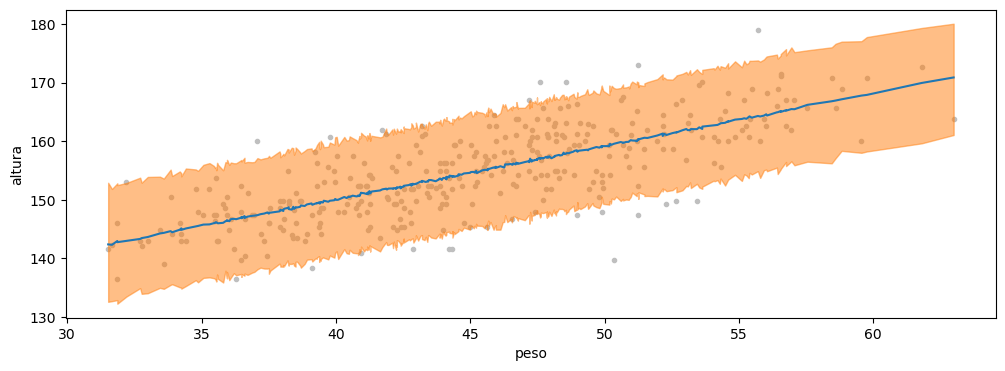

In [18]:
linea_media = idata_rh1.posterior_predictive['y_pred'].mean(("chain", "draw"))
idx = np.argsort(x_3.values)
x = np.linspace(x_3.min(), x_3.max(), 346)
lineas_hdi = az.hdi(idata_rh1.posterior_predictive["y_pred"])

_, ax = plt.subplots(figsize=(12, 4))
ax.plot(x_3, y_3, '.', color="0.75",  zorder=-3)
ax.plot(x_3[idx], linea_media[idx], c='C0')

ax.fill_between(x_3[idx],lineas_hdi["y_pred"][:,0][idx],lineas_hdi["y_pred"][:,1][idx],color="C1", alpha=0.5)


ax.set_xlabel('peso')
ax.set_ylabel('altura')

En mi modelo defini:
- alpha: el intercepto del factor lineal. Con media de 114cm
- beta: la pendiente del factor lineal. Con media 0.9cm/kg
- sigma: el ruido a partir del cual se generan las diferencias con la media. Media 5.1cm

A partir del modelo, obtuve buenas predicciones sobre la altura (hay muy pocos valores por fuera del area naranja, el hdi 94%, por lo que tiene sentido.)

## Ejercicio 5
Para 4 individuos se registraron los pesos (45.73, 65.8, 54.2, 32.59), pero no las alturas. Usando el modelo del punto anterior prediga la altura esperada para cada individuo junto con un intervalo de credibilidad del 50% y del 89%.

$\beta$

In [19]:
nuevos_individuos = [45.73, 65.8, 54.2, 32.59]

### Con bambi

In [20]:
modelo.predict(idata, kind = 'pps',data=pd.DataFrame({'peso':nuevos_individuos}))

In [21]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

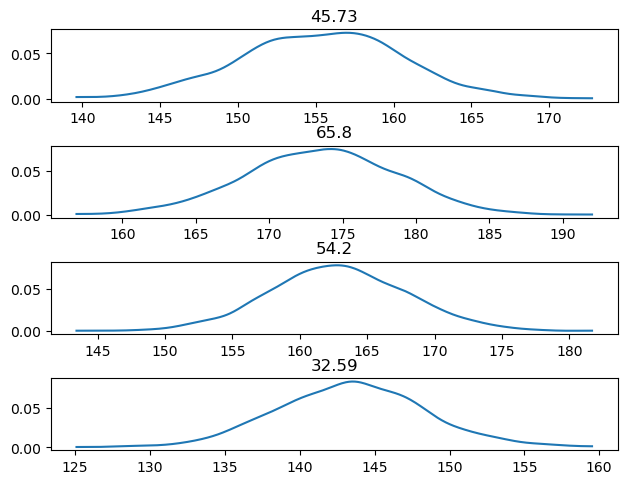

In [22]:
fig, ax = plt.subplots(4,1)
plt.tight_layout()
for i in range(4):
    y_ppc = idata.posterior_predictive["altura"].stack(sample=("chain", "draw"))[i]
    grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values)
    ax[i].plot(grid, pdf)
    ax[i].set_title(str(nuevos_individuos[i]))


### Con PYMC

In [23]:
datos_nuevos = [45.73, 65.8, 54.2, 32.59]
with regresion_howell_1:
    pm.set_data({"x_shared": [45.73, 65.8, 54.2, 32.59]})
    ppc = pm.sample_posterior_predictive(idata_rh1, random_seed=123)
    y_ppc = ppc.posterior_predictive['y_pred'].stack(sample=("chain", "draw"))

Sampling: [y_pred]


Output()

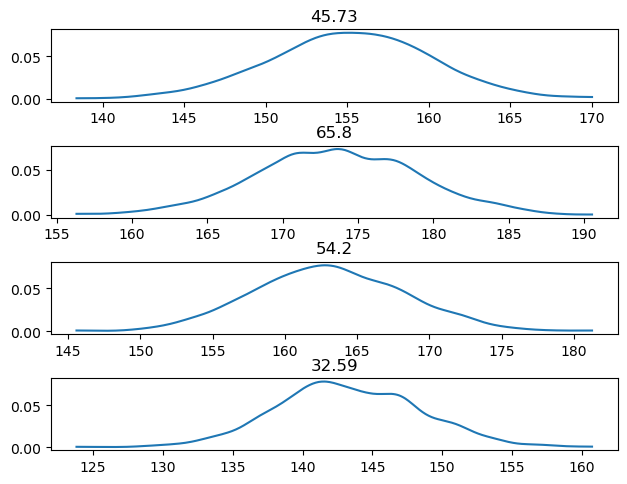

In [24]:
fig, ax= plt.subplots(4,1)
plt.tight_layout()
for i in range(4):
    grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values[i])
    ax[i].plot(grid, pdf)
    ax[i].set_title(str(nuevos_individuos[i]))

Con esto vemos las distintas distribuciones de probabilidad para las predicciones de los nuevos valores.

## Ejercicio 6
Repita el punto 4 pero para los menores de 18 años. Exponga los resultados.


In [25]:
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import xarray as xr
import bambi as bmb

In [26]:
howell = pd.read_csv("datos/howell.csv", delimiter= ";")

howell.head()

,altura,peso,edad,sexo
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


<Axes: xlabel='peso', ylabel='altura'>

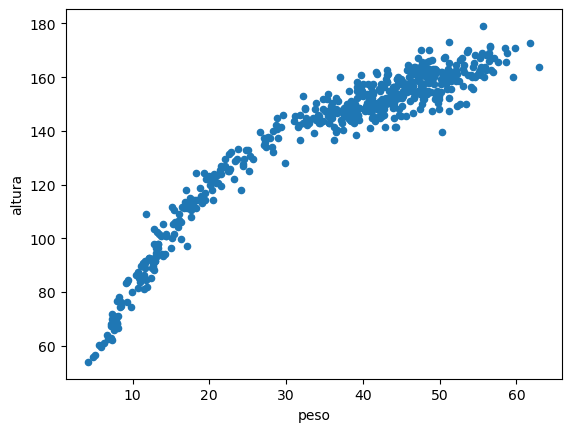

In [27]:
howell.plot("peso","altura",kind = "scatter")

In [43]:
howell_menores = howell.loc[howell["edad"] < 18, :]
howell_menores.reset_index(inplace=True)
x_3 = howell_menores.peso
y_3 = howell_menores.altura

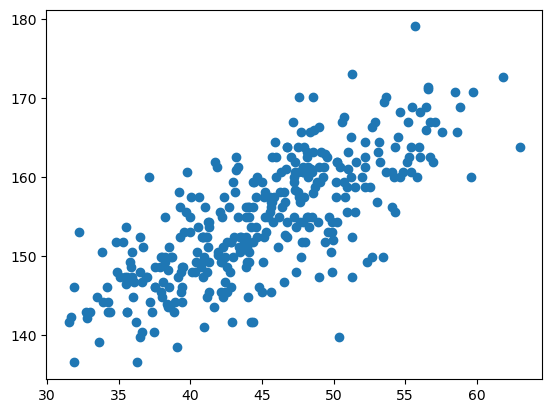

In [29]:
plt.scatter(x_3,y_3)

### Con bambi

In [44]:
modelo = bmb.Model('altura ~ peso', howell_menores)

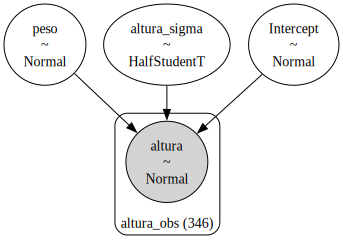

In [31]:
modelo.build()
modelo.graph()


In [45]:
idata = modelo.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [altura_sigma, Intercept, peso]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


c:\Users\admin\anaconda3\envs\estadistica2\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
c:\Users\admin\anaconda3\envs\estadistica2\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


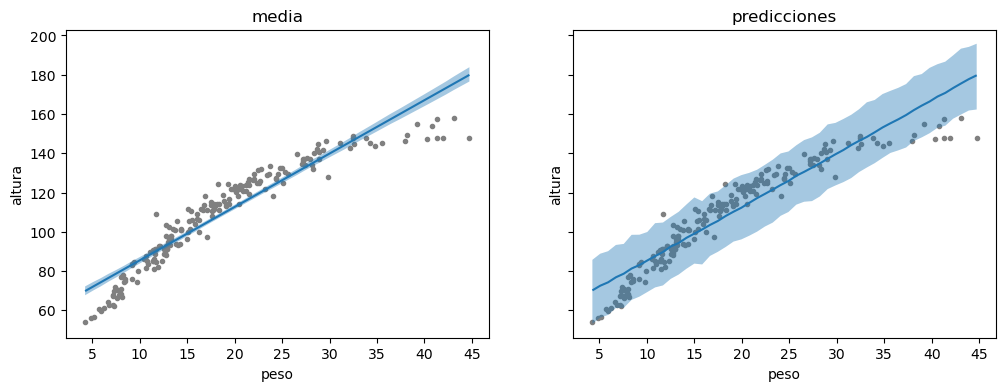

In [46]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4)) 
bmb.interpret.plot_predictions(modelo, idata, "peso", ax=axes[0])
bmb.interpret.plot_predictions(modelo, idata, "peso", pps=True, ax=axes[1])

axes[0].plot(howell_menores.peso, howell_menores.altura, ".", color="0.5",  zorder=-3)
axes[1].plot(howell_menores.peso, howell_menores.altura, ".", color="0.5", zorder=-3)
axes[0].set_title("media")
axes[1].set_title("predicciones");

In [48]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,58.266,1.486,55.548,61.080,0.027,0.019,3062.0,1481.0,1.0
altura_sigma,8.547,0.448,7.654,9.340,0.008,0.006,3171.0,1627.0,1.0
peso,2.719,0.072,2.586,2.854,0.001,0.001,2730.0,1518.0,1.0


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'altura_sigma'}>,
       <Axes: title={'center': 'peso'}>], dtype=object)

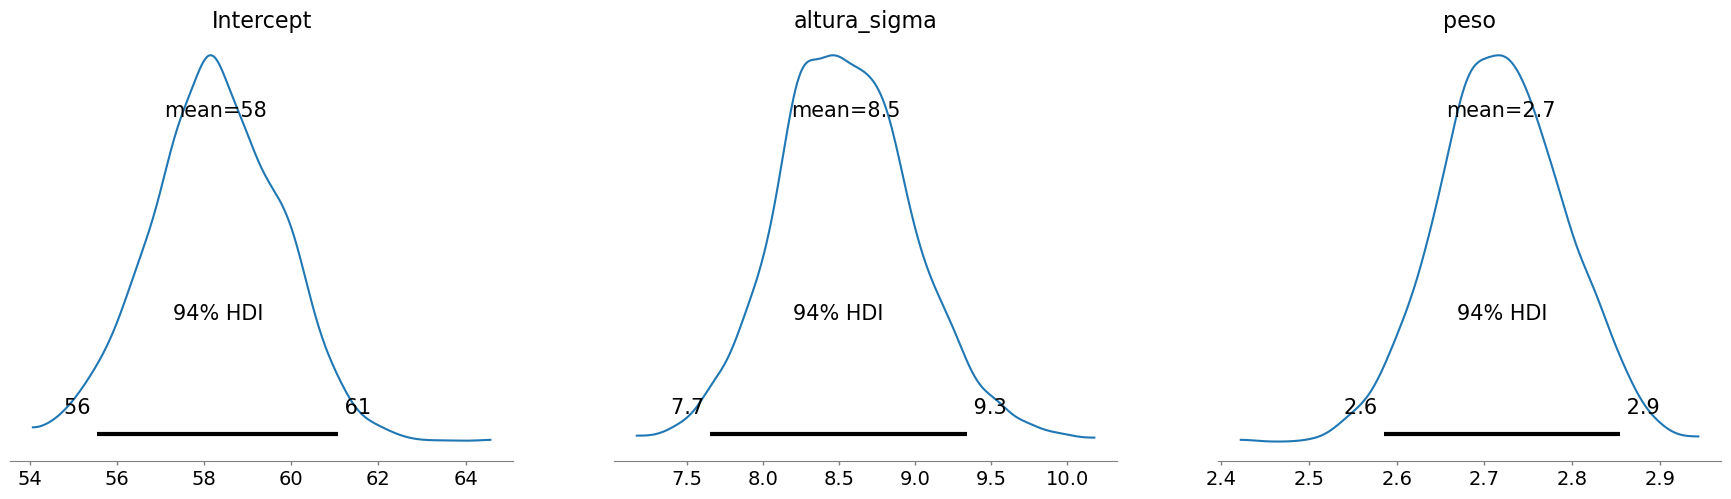

In [47]:
az.plot_posterior(idata)

### Con PYMC

Lo planteo como 

y ~ Normal($\mu$,$\sigma$)

$\mu$ = $\alpha$ + $\beta$ x

$\alpha$ ~ Normal(0,50)

$\beta$ ~ Normal(0,50)

$\sigma$ ~ HalfNormal(50)


Elijo 50 como hiperparametro ya que: 100 me parece mucho.

[insertar explicacion teorica de porque]

In [49]:
with pm.Model() as regresion_howell_2:
    x_shared = pm.Data("x_shared",x_3.values.astype(float))
    α = pm.Normal('α', mu=0, sigma=100)
    β = pm.Normal('β', mu=0, sigma=100)
    σ = pm.HalfNormal('σ', 100)
    μ = pm.Deterministic('μ', α + β * x_shared)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=y_3, shape = x_shared.shape)

In [50]:
with regresion_howell_2:
    idata_rh2 = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [α, β, σ]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

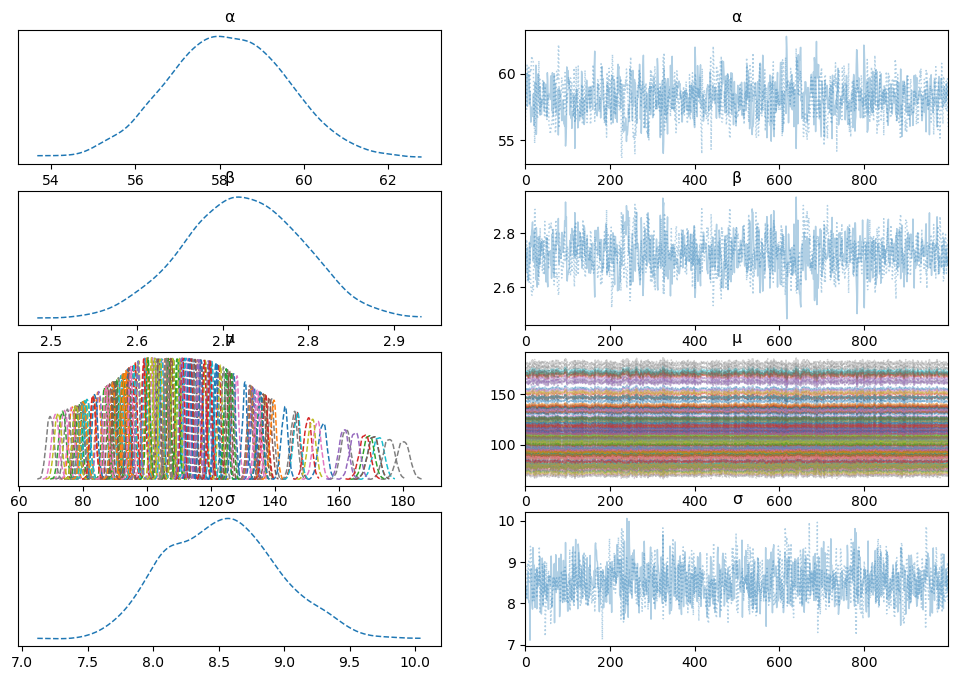

In [51]:
az.plot_trace(idata_rh2, combined=True)

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

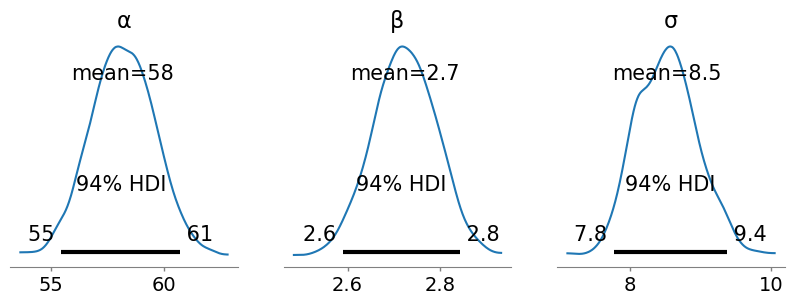

In [52]:
az.plot_posterior(idata_rh2, var_names=['~μ'], figsize=(10, 3))

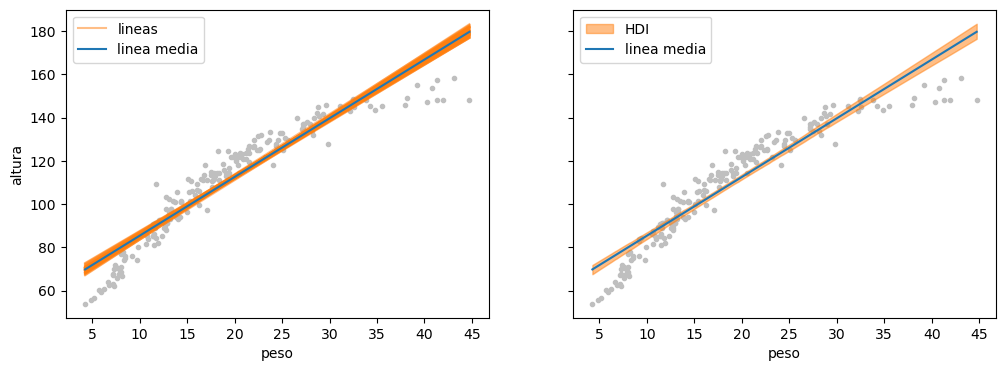

In [53]:
posterior = az.extract(idata_rh2, num_samples=50)
x_plot = xr.DataArray(np.linspace(x_3.min(), x_3.max(), 50), dims="plot_id")
linea_media = posterior['α'].mean() + posterior['β'].mean() * x_plot
lineas = posterior['α'] + posterior['β'] * x_plot
hdi_lines = az.hdi(idata_rh2.posterior['μ'])


fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(x_3, y_3,  '.', color="0.75",  zorder=-3)
lines_ = axes[0].plot(x_plot, lineas.T, c='C1', alpha=0.5, label='lineas')
plt.setp(lines_[1:], label="_")
axes[0].plot(x_plot, linea_media, c='C0', label='linea media')
axes[0].set_xlabel('peso')
axes[0].set_ylabel('altura')
axes[0].legend()

axes[1].plot(x_3, y_3, '.', color="0.75",  zorder=-3)
idx = np.argsort(x_3.values)
axes[1].fill_between(x_3[idx], hdi_lines["μ"][:,0][idx], hdi_lines["μ"][:,1][idx],
                     color="C1", label='HDI', alpha=0.5)
axes[1].plot(x_plot, linea_media, c='C0', label='linea media')
axes[1].set_xlabel('peso')
axes[1].legend();

In [54]:
pm.sample_posterior_predictive(idata_rh2, model=regresion_howell_2, extend_inferencedata=True, random_seed=123)

Sampling: [y_pred]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

Text(0, 0.5, 'altura')

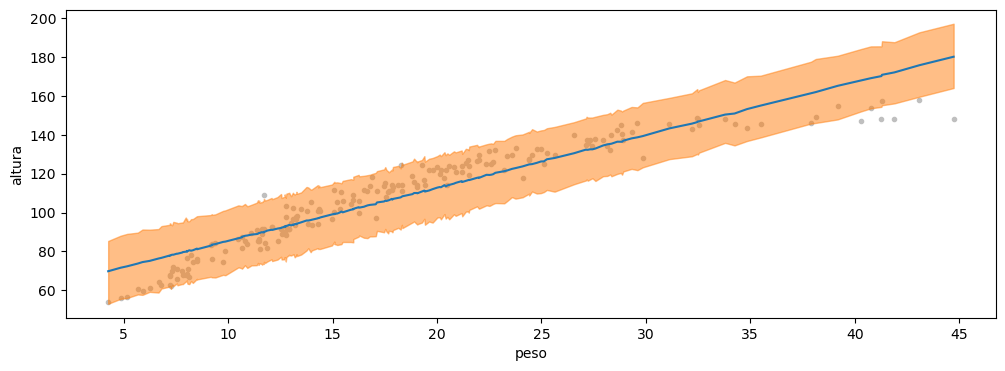

In [55]:
linea_media = idata_rh2.posterior_predictive['y_pred'].mean(("chain", "draw"))
idx = np.argsort(x_3.values)
x = np.linspace(x_3.min(), x_3.max(), 346)
lineas_hdi = az.hdi(idata_rh2.posterior_predictive["y_pred"])

_, ax = plt.subplots(figsize=(12, 4))
ax.plot(x_3, y_3, '.', color="0.75",  zorder=-3)
ax.plot(x_3[idx], linea_media[idx], c='C0')

ax.fill_between(x_3[idx],lineas_hdi["y_pred"][:,0][idx],lineas_hdi["y_pred"][:,1][idx],color="C1", alpha=0.5)


ax.set_xlabel('peso')
ax.set_ylabel('altura')

En mi modelo defini:
- alpha: el intercepto del factor lineal. Con media de 114cm
- beta: la pendiente del factor lineal. Con media 0.9cm/kg
- sigma: el ruido a partir del cual se generan las diferencias con la media. Media 5.1cm

A partir del modelo, obtuve buenas predicciones sobre la altura (hay muy pocos valores por fuera del area naranja, el hdi 94%, por lo que tiene sentido.)

Debería modificar la función de enlace para un mejor ajuste, quizás un logaritmo?

## Ejercicio 7
Use el modelo `modelo_bl` pero aplicada al conjunto de datos iris. Intente clasificar setosa o versicolor en función de `sepal_length`. ¿Cuán útil es este modelo comparado con una regresión logística? 



In [57]:
data = pd.read_csv('datos/iris.csv')
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [59]:
#setosa o versicolor
set_vers = data.loc[data['species'] == 'setosa' | data['species'] == 'versicolor']

TypeError: Cannot perform 'ror_' with a dtyped [object] array and scalar of type [bool]

In [ ]:
with pm.Model() as modelo_bl:
    α = pm.Normal('α', mu=0, sigma=100)
    β = pm.Normal('β', mu=0, sigma=10)
    σ = pm.HalfCauchy('σ', 10)
    μ = pm.Deterministic('μ', α + β * bicis.temperatura)
    _ = pm.Normal('y_pred', mu=μ, sigma=σ, observed=bicis.alquiladas)

pm.model_to_graphviz(modelo_bl)

8. Vuelva a correr el `modelo_rl` pero esta vez usando la variable `petal_width` ¿En que difieren los resultados? ¿Cuán ancho o angosto es el intervalo HDI 94%? 




9. Lea este [post](https://twiecki.github.io/blog/2017/02/08/bayesian-hierchical-non-centered/) y replique los resultados usted mismo.